# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
from torchvision import transforms, utils
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler



# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [3]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
data_dir = '/data/landmark_images'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

data_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
             transforms.Normalize([0, 0, 0], [1, 1, 1])])

train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                    transforms.RandomRotation(2),                                      
                                    transforms.ToTensor(),
                                    transforms.Normalize([0, 0, 0], [1, 1, 1])])

train_data_t = datasets.ImageFolder(train_dir, transform=train_transform)
train_data_v = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data_t))
print('Num test images: ', len(test_data))

Num training images:  4996
Num test images:  1250


In [4]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2



# obtain training indices that will be used for validation
num_train = len(train_data_v)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data_t, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data_v, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['Haleakala National Park','Mount Rainier National Park','Ljubljana Castle','Dead Sea','Wroclaws Dwarves',
           'London Olympic Stadium','Niagara Falls','Stonehenge','Grand Canyon','Golden Gate Bridge','Edinburgh Castle',
           'Mount Rushmore National Memorial','Kantanagar Temple','Yellowstone National Park','Terminal Tower','Central Park',
           'Eiffel Tower','Changdeokgung','Delicate Arch','Vienna City Hall','Matterhorn','Taj Mahal','Moscow Raceway','Externsteine',
           'Soreq Cave','Banff National Park','Pont du Gard','Seattle Japanese Garden','Sydney Harbour Bridge','Petronas Towers',
           'Brooklyn Bridge','Washington Monument','Hanging Temple','Sydney Opera House','Great Barrier Reef','Monumento a la Revolucion',
           'Badlands National Park','Atomium','Forth Bridge','Gateway of India','Prague Astronomical Clock','Stockholm City Hall',
           'Machu Picchu','Death Valley National Park','Gullfoss Falls','Trevi Fountain','Temple of Heaven','Great Wall of China',
           'Whitby Abbey','Temple of Olympian Zeus']


loaders_scratch = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**:

First, the size of an image was selected by cropping to 224 for all data in trainig data and valid data and test data. This was done by transforms.RandomResizedCrop(224). The size was chosen randomly.
Also, the data in the train data is has already been augmented by Random Horizontal Flip, and Random Rotation by 2 degree This was done by transforms.RandomHorizontalFlip(), transforms.RandomRotation(10). 

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

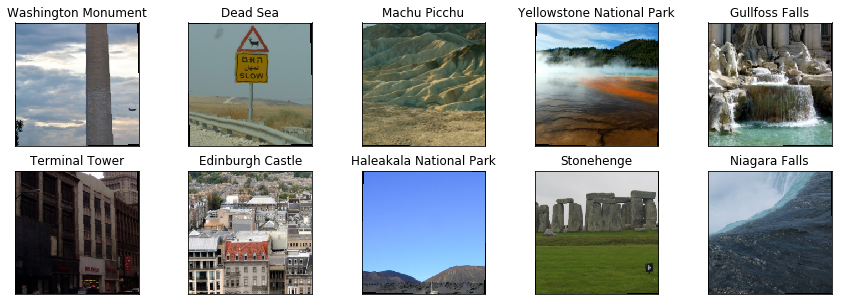

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(15, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Initialize use_cuda variable

In [6]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [7]:
## TODO: select loss function
import torch.nn as nn

criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    return torch.optim.Adagrad(model.parameters(), lr=0.01)

    ## TODO: select and return an optimizer

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
CUDA_LAUNCH_BLOCKING=1 

In [9]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self, constant_weight=None):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(512, 50)

        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)
        
        if(constant_weight is not None):
            for m in self.modules():                    
                if isinstance(m,(nn.Conv2d, nn.Linear)):
                    nn.init.constant_(m.weight, constant_weight)
                    nn.init.constant_(m.bias, 0)
    

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(x.size(0), 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)

        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x
        
    
#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=50, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__

firstly i constructing CNN that take image with size 224*224 pixle and the dipth are 3 beasuse the image has 3 channels. The first layer is a convolution layer with 16 filter and the kernal size is 3x3 and move it 3 steps at a time, and i want to pad the image, so that i give the padding 1.
The second convolution layer take the output from the first convolution layer and apply 32 filter on it, and the kernal size also 3*3 and and move it 3 pixels at a time, and i want to pad the image.
The last convolution laye take output from the second convolution layer and apply 64 filter on it, and the kernal size also 3*3 and and move it 3 pixels at a time, and i want to pad the image.

Pooling layers take in a kernel with size  2*2 and stride 2 step at a time. 
and i give my CNN 2 fully connected layer:
the first fully connected layer take the output from the last convolution layer(64*28*28) as input and the output from it is 512 because i have 512 heddin layer. 
the second fully connected layer take the output from the first fully connected layer as input and the output from it is 50 because i have 50 classes in my dataset.

and in the forward function for every convolution layer i apply relu activation function on the output from it and apply max pooling.
I apply the flatten on the output from the last connected layer. I add dropout layer between the flatten and fc1, and between fcl1 and fc2


### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [10]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
        """returns trained model"""
        # initialize tracker for minimum validation loss
        valid_loss_min = np.Inf 

        for epoch in range(1, n_epochs+1):
            # initialize variables to monitor training and validation loss
            train_loss = 0.0
            valid_loss = 0.0

            ###################
            # train the model #
            ###################
            # set the module to training mode
            model.train()
            for batch_idx, (data, target) in enumerate(loaders['train']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                    optimizer.zero_grad()
                    # forward pass: compute predicted outputs by passing inputs to the model
                    output = model(data)
                    # calculate the batch loss
                    loss = criterion(output, target)
                    # backward pass: compute gradient of the loss with respect to model parameters
                    loss.backward()
                    # perform a single optimization step (parameter update)
                    optimizer.step()
                    # update training loss
                    train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))         

                ## TODO: find the loss and update the model parameters accordingly
                ## record the average training loss, using something like
                ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))         


            ######################    
            # validate the model #
            ######################
            # set the model to evaluation mode
            model.eval()
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    # calculate the batch loss
                    loss = criterion(output, target)
                    # update average validation loss 
                    valid_loss += loss.item()*data.size(0)
                    ## TODO: update average validation loss 
            # calculate average losses
            train_loss = train_loss/len(train_loader.dataset)
            valid_loss = valid_loss/len(valid_loader.dataset)


            # print training/validation statistics 
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))

            ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path

            if valid_loss <= valid_loss_min:
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
                    torch.save(model.state_dict(), 'model_scratch.pt')
                    valid_loss_min = valid_loss


        return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [11]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        m.weight.data.normal_(0.0, 0.02)
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0,  y)
        m.bias.data.fill_(0)
    

#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 0.000857 	Validation Loss: 0.781817
Validation loss decreased (inf --> 0.781817).  Saving model ...
Epoch: 2 	Training Loss: 0.000771 	Validation Loss: 0.764647
Validation loss decreased (0.781817 --> 0.764647).  Saving model ...
Epoch: 3 	Training Loss: 0.000760 	Validation Loss: 0.757307
Validation loss decreased (0.764647 --> 0.757307).  Saving model ...
Epoch: 4 	Training Loss: 0.000752 	Validation Loss: 0.745120
Validation loss decreased (0.757307 --> 0.745120).  Saving model ...
Epoch: 5 	Training Loss: 0.000746 	Validation Loss: 0.741653
Validation loss decreased (0.745120 --> 0.741653).  Saving model ...
Epoch: 6 	Training Loss: 0.000741 	Validation Loss: 0.733168
Validation loss decreased (0.741653 --> 0.733168).  Saving model ...
Epoch: 7 	Training Loss: 0.000733 	Validation Loss: 0.729235
Validation loss decreased (0.733168 --> 0.729235).  Saving model ...
Epoch: 8 	Training Loss: 0.000725 	Validation Loss: 0.718234
Validation loss decreased (0.72923

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [12]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 50

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 0.000869 	Validation Loss: 0.779806
Validation loss decreased (inf --> 0.779806).  Saving model ...
Epoch: 2 	Training Loss: 0.000766 	Validation Loss: 0.747333
Validation loss decreased (0.779806 --> 0.747333).  Saving model ...
Epoch: 3 	Training Loss: 0.000730 	Validation Loss: 0.724664
Validation loss decreased (0.747333 --> 0.724664).  Saving model ...
Epoch: 4 	Training Loss: 0.000704 	Validation Loss: 0.691073
Validation loss decreased (0.724664 --> 0.691073).  Saving model ...
Epoch: 5 	Training Loss: 0.000688 	Validation Loss: 0.675602
Validation loss decreased (0.691073 --> 0.675602).  Saving model ...
Epoch: 6 	Training Loss: 0.000676 	Validation Loss: 0.668172
Validation loss decreased (0.675602 --> 0.668172).  Saving model ...
Epoch: 7 	Training Loss: 0.000664 	Validation Loss: 0.653869
Validation loss decreased (0.668172 --> 0.653869).  Saving model ...
Epoch: 8 	Training Loss: 0.000651 	Validation Loss: 0.645100
Validation loss decreased (0.65386

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [13]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.224693


Test Accuracy: 43% (539/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [14]:
loaders_transfer = loaders_scratch.copy()

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [15]:
## TODO: select loss function
import torch.nn as nn

criterion_transfer = nn.CrossEntropyLoss()

def get_optimizer_transfer(model):
    return torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) 

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
## TODO: Specify model architecture
import torchvision

#model_transfer = models.resnet50(pretrained=True).to(device)
#model_transfer = models.vgg16(pretrained=True)
#model_transfer = models.inception_v3(pretrained=True)
model_transfer = torchvision.models.densenet121(pretrained=True)    

print(model_transfer)


#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 71715197.82it/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [ ]:
# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False  

In [18]:
num_ftrs = model_transfer.classifier.in_features
model_transfer.classifier = nn.Linear(num_ftrs, 50)
model_transfer = model_transfer.to(device)


__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  __ Answer:__ I'm really was try the different model such as vgg16 and inception_v3 and resnet50, and i were get the high accuracy when i use densenet121. So this i see the the densenet121 is suitable model to use it in the transfer learning here.

Test Accuracy of vgg16: 52% (653/1250), 
Test Accuracy of resnet59: 60% (751/1250),Test Accuracy of densenet121: 80% (1003/1250).



### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [19]:
model_transfer = train(10 ,loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.000596 	Validation Loss: 0.333240
Validation loss decreased (inf --> 0.333240).  Saving model ...
Epoch: 2 	Training Loss: 0.000335 	Validation Loss: 0.243614
Validation loss decreased (0.333240 --> 0.243614).  Saving model ...
Epoch: 3 	Training Loss: 0.000254 	Validation Loss: 0.198141
Validation loss decreased (0.243614 --> 0.198141).  Saving model ...
Epoch: 4 	Training Loss: 0.000214 	Validation Loss: 0.181472
Validation loss decreased (0.198141 --> 0.181472).  Saving model ...
Epoch: 5 	Training Loss: 0.000184 	Validation Loss: 0.174676
Validation loss decreased (0.181472 --> 0.174676).  Saving model ...
Epoch: 6 	Training Loss: 0.000163 	Validation Loss: 0.173634
Validation loss decreased (0.174676 --> 0.173634).  Saving model ...
Epoch: 7 	Training Loss: 0.000145 	Validation Loss: 0.164555
Validation loss decreased (0.173634 --> 0.164555).  Saving model ...
Epoch: 8 	Training Loss: 0.000135 	Validation Loss: 0.159621
Validation loss decreased (0.16455

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [20]:
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'),strict=False)
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.577099


Test Accuracy: 85% (1065/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [21]:
import cv2
from PIL import Image
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    img = cv2.imread('img_path')
    pil_img = Image.open(img_path).convert('RGB')
    img_t = data_transform(pil_img)
    batch_t = torch.unsqueeze(img_t, 0)
    batch_t = batch_t.cuda()
    model_transfer.eval()
    outputs = model_transfer(batch_t)
    _, preds_tensor = torch.topk(outputs, k)
    for j in range(k):
        print(classes[preds_tensor[0].cpu().numpy()[j]])
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN

In [22]:
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

Golden Gate Bridge
Forth Bridge
Brooklyn Bridge
Dead Sea
Sydney Harbour Bridge


### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

Is this picture of the 
Golden Gate Bridge
Forth Bridge
Brooklyn Bridge
Dead Sea
Sydney Harbour Bridge


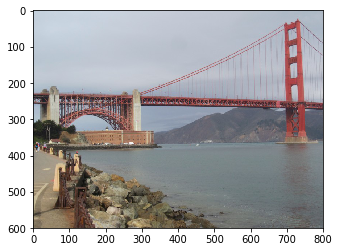

In [23]:
def suggest_locations(img_path):
    # get landmark predictions
    print('Is this picture of the ')
    predicted_landmarks = predict_landmarks(img_path, 5)

    # plot the images in the batch, along with predicted and true labels
    img = cv2.imread('img_path')
    pil_img = Image.open(img_path).convert('RGB')
    plt.imshow(pil_img)
    #('this is picture of the')

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 
Realy the output is better than i expecte, my algorithm is working better.
1- I am looking forward to predicte the not clear image correctly. 
2- I am looking forward to an increase in accuracy of scratch model more than 43%.
3- I am looking forward to an increase in accuracy of tranfer model more than 85% and try more model.


Is this picture of the 
Edinburgh Castle
Niagara Falls
Eiffel Tower
Temple of Olympian Zeus
Temple of Heaven


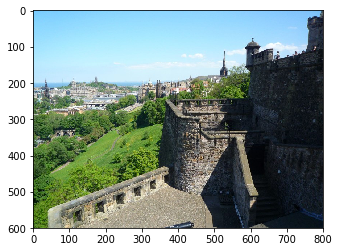

In [24]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('/data/landmark_images/test/10.Edinburgh_Castle/1ac266642bca9a1b.jpg')

Is this picture of the 
Eiffel Tower
Forth Bridge
Sydney Harbour Bridge
Terminal Tower
London Olympic Stadium


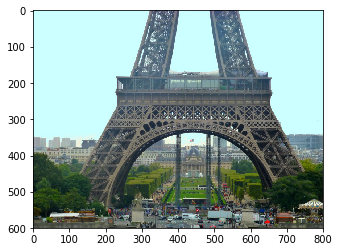

In [25]:
suggest_locations('/data/landmark_images/test/16.Eiffel_Tower/4d5545525a2ec91c.jpg')

Is this picture of the 
Washington Monument
Golden Gate Bridge
Moscow Raceway
Sydney Harbour Bridge
Terminal Tower


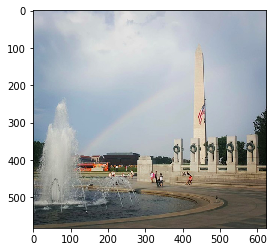

In [35]:
suggest_locations('/data/landmark_images/test/31.Washington_Monument/1fc55173a1982d99.jpg')

Is this picture of the 
Petronas Towers
Terminal Tower
Sydney Opera House
Washington Monument
Mount Rainier National Park


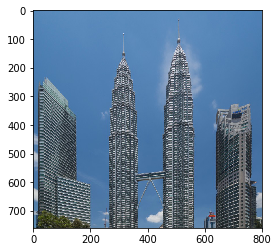

In [36]:
suggest_locations('/data/landmark_images/test/29.Petronas_Towers/0963ead61e978054.jpg')

Is this picture of the 
Grand Canyon
Delicate Arch
Badlands National Park
Dead Sea
Soreq Cave


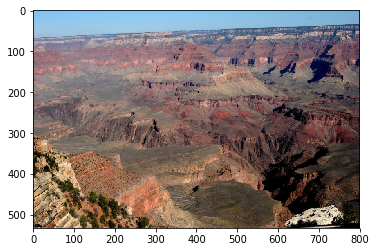

In [37]:
suggest_locations('/data/landmark_images/test/08.Grand_Canyon/1c5b3dc0d9836e8a.jpg')